# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.
  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?
  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?
  12. Which model --- linear model or classification and regression tree --- has better performance on the test set?

    Price   Color  Seating_Capacity  Body_Type        Make  Make_Year  \
0  657000  silver                 5      sedan  Volkswagen       2017   
1  682000     red                 5  crossover     Hyundai       2016   
2  793000   white                 5        suv       Honda       2019   
3  414000  bronze                 5  hatchback     Renault       2017   
4  515000  orange                 5  hatchback     Hyundai       2017   

   Mileage_Run Fuel_Type Transmission Transmission_Type  
0        44611    diesel      7-Speed         Automatic  
1        20305    petrol      5-Speed            Manual  
2        29540    petrol      5-Speed            Manual  
3        35680    petrol      5-Speed            Manual  
4        25126    petrol      5-Speed            Manual  
              Price  Seating_Capacity    Make_Year   Mileage_Run
count  9.760000e+02        976.000000   976.000000    976.000000
mean   7.410195e+05          5.095287  2016.963115  41571.195697
std    3.673234e+0

<Axes: >

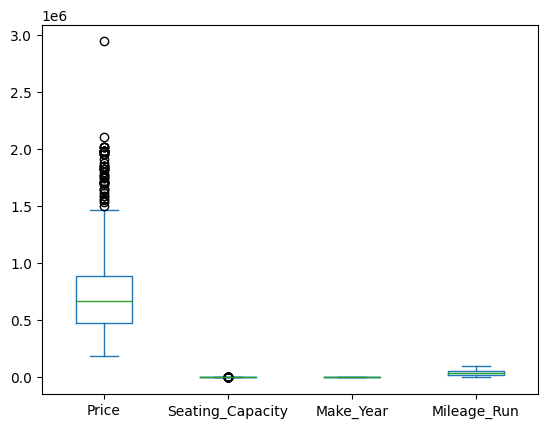

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures

def windsorize(x):
    # Compute IQR and 1st,3rd quantiles
    pct25, pct75 = np.percentile(x,[25,75])
    iqr = pct75 - pct25
    # Compute whiskers:
    lower_whisker = pct25 - iqr*1.5
    upper_whisker = pct75 + iqr*1.5
    # Windsorize x:
    x_windsor = x
    x_windsor[ x < lower_whisker ] = lower_whisker
    x_windsor[ x > upper_whisker ] = upper_whisker
    return(x_windsor)

df = pd.read_csv('./sample_data/cars_hw.csv')
df = df[['Price', 'Color', 'Seating_Capacity', 'Body_Type', 'Make', 'Make_Year', 'Mileage_Run', 'Fuel_Type', 'Transmission', 'Transmission_Type']]
print(df.head())
print(df.describe())
df.head()
print(df.dtypes)
df.plot.box()

In [56]:
windsorize(df['Price']) #Cleaning up Price as there are lot of outliers

<ipython-input-55-8dbd715f11f0>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_windsor[ x > upper_whisker ] = upper_whisker


0       657000
1       682000
2       793000
3       414000
4       515000
        ...   
971     956000
972    1027000
973     736000
974     749000
975     691000
Name: Price, Length: 976, dtype: int64

<Axes: >

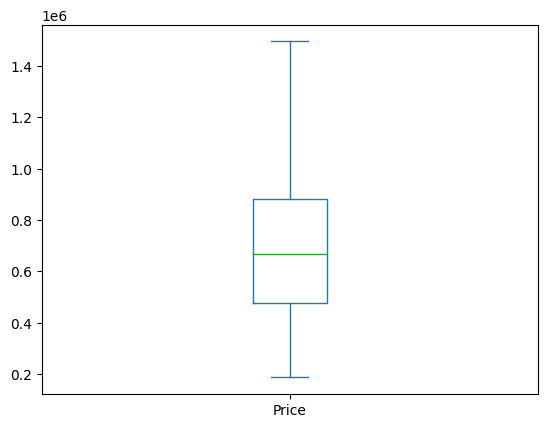

In [57]:
df["Price"].plot.box()

In [58]:
#2
price_summary = df.groupby("Make")["Price"].describe()
print(price_summary)

               count          mean            std        min         25%  \
Make                                                                       
Chevrolet        6.0  4.535000e+05  246606.366503   267000.0   288500.00   
Datsun           3.0  2.896667e+05   10503.967504   279000.0   284500.00   
Ford            52.0  7.211731e+05  140927.699605   290000.0   635000.00   
Honda           73.0  7.983818e+05  264893.305869   316000.0   581000.00   
Hyundai        305.0  6.910783e+05  276437.697587   248000.0   485000.00   
Jeep             4.0  1.442906e+06  101937.500000  1290000.0  1442906.25   
Kia              8.0  1.478266e+06   44149.979650  1369000.0  1493875.00   
MG Motors       35.0  1.493875e+06       0.000000  1493875.0  1493875.00   
Mahindra        18.0  1.100167e+06  175549.305961   796000.0  1037000.00   
Maruti Suzuki  293.0  5.887850e+05  216019.860943   237000.0   411000.00   
Nissan           4.0  8.842500e+05  289559.867155   475000.0   782500.00   
Renault     

<ipython-input-59-979c9d36d281>:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x="Price", hue="Make")


<Axes: xlabel='Price', ylabel='Density'>

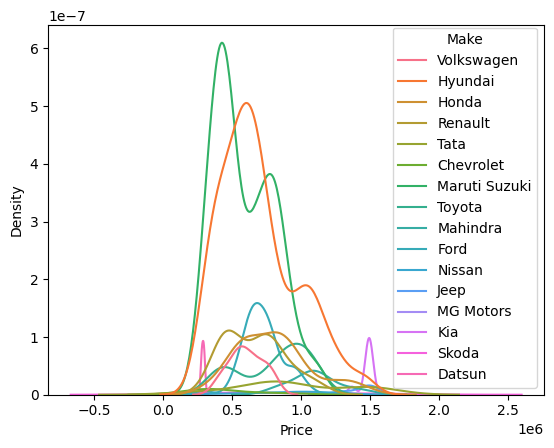

In [59]:
sns.kdeplot(data=df, x="Price", hue="Make")

It looks like kia is the expensive car brand, looking at the far right. Nissan and Hyundai aree popular cars with being in the medium range of expensive.

In [60]:
#3
train_set, test_set = train_test_split(df, test_size=0.2, random_state=1)

In [61]:
#4 Num Var
y = df["Price"]
num_vars = ['Seating_Capacity', 'Make_Year', 'Mileage_Run']
X1 = df.loc[:,num_vars]

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=1)
reg = LinearRegression().fit(X_train, y_train)

print("R2: ",reg.score(X1, y))
y_pred = reg.predict(X_test)
print("RSME: ",np.sqrt(mean_squared_error(y_test, y_pred)))

R2:  0.35270063917604344
RSME:  243861.06360669615


In [62]:
cat_vars = ['Fuel_Type', 'Transmission', 'Transmission_Type', 'Color', 'Body_Type', 'Make']
X2 = df.loc[:,cat_vars]
X2 = pd.get_dummies(X2 ,dtype='int') # One-hot encode the variable

X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=1)
reg = LinearRegression().fit(X_train, y_train)

print("R2: ",reg.score(X2, y))
y_pred = reg.predict(X_test)
print("RSME: ",np.sqrt(mean_squared_error(y_test, y_pred)))

R2:  0.7168203238708101
RSME:  173889.44631864553


Category variables did better than number variables.

In [63]:
#4.3 Both
X3 = pd.concat([X1, X2], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=1)
reg = LinearRegression().fit(X_train, y_train)

print("R2: ",reg.score(X3, y))
y_pred = reg.predict(X_test)
print("RSME: ",np.sqrt(mean_squared_error(y_test, y_pred)))

R2:  0.8350629634417641
RSME:  138298.48229566857


Combine both of them. Does a better job than having them separately. It did .12 better in R2 value vs the category variables.

Use the PolynomialFeatures function from sklearn to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the  𝑅2  and RMSE change? At what point does  𝑅2  go negative on the test set? For your best model with expanded features, what is the  𝑅2  and RMSE? How does it compare to your best model from part 3?

In [64]:
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X3) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
zdf = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
zdf.head()

X_train, X_test, y_train, y_test = train_test_split(zdf, y, test_size=0.2, random_state=1)
reg = LinearRegression().fit(X_train, y_train) # Fit the linear model

print("R2: ",reg.score(zdf, y)) # R squared measure
y_pred = reg.predict(X_test)
print("RSME: ",np.sqrt(mean_squared_error(y_test, y_pred)))

R2:  -5317.078593123627
RSME:  50650815.444830336


In [65]:
expander = PolynomialFeatures(degree=4,include_bias=False) # Create the expander
Z = expander.fit_transform(X3) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
zdf = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
zdf.head()

X_train, X_test, y_train, y_test = train_test_split(zdf, y, test_size=0.2, random_state=1)
reg = LinearRegression().fit(X_train, y_train)

print("R2: ",reg.score(zdf, y))
y_pred = reg.predict(X_test)
print("RSME: ",np.sqrt(mean_squared_error(y_test, y_pred)))

R2:  -1656.5479101835233
RSME:  28277227.768656947


In [66]:
expander = PolynomialFeatures(degree=3,include_bias=False) # Create the expander
Z = expander.fit_transform(X3) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
zdf = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
zdf.head()

X_train, X_test, y_train, y_test = train_test_split(zdf, y, test_size=0.2, random_state=1)
reg = LinearRegression().fit(X_train, y_train)

print("R2: ",reg.score(zdf, y))
y_pred = reg.predict(X_test)
print("RSME: ",np.sqrt(mean_squared_error(y_test, y_pred)))

R2:  -29734.59390825999
RSME:  119770282.9909884


As the degree goes up, our r2 value goes less negative up until degree 4 where r2 goes more negative. The best degree was at 3. where R2:-1656.5479101835233 and RSME:  28277227.768656947. This model performed way worse than the LinearRegression with both num/categories variables.

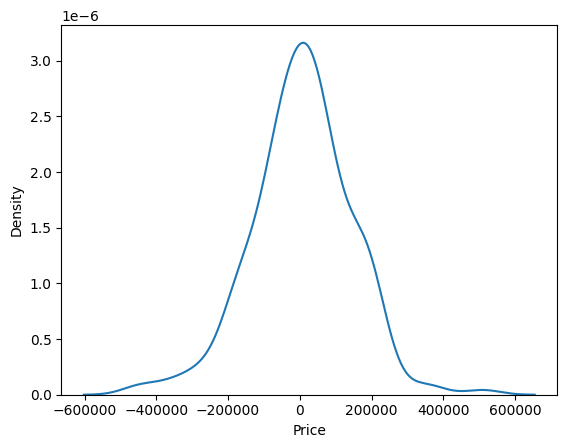

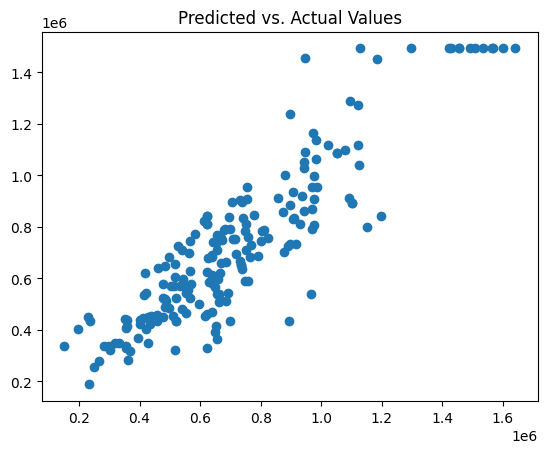

In [67]:
#6 Category variables & number variables.
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=1)
reg = LinearRegression().fit(X_train, y_train)

# Predicted values:
y_hat_lm = reg.predict(X_test)
residuals_lm = y_test - y_hat_lm

## Residual plot:
sns.kdeplot(residuals_lm)
plt.show()

## True versus predicted plot:
plt.scatter(x=y_hat_lm,y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()

The the predicted values and true values do roughly line up along the diagonal. There are some of them that are off such as the top right of the graph. The kernel density plot does have a bell shape around zero. This is a good model as it predicts pretty good compared to the other models. It has the highest r2 value out of all them. The only weakness is that high prices (outliers) would get it wrong. Category variables & number variables with Linear Reg was the best model.

Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the max_depth option (i.e. tree.DecisionTreeRegressor(max_depth=D)), and compute the  𝑅2  and RMSE on the test set of a variety of depths. What depth tree gives the best results?

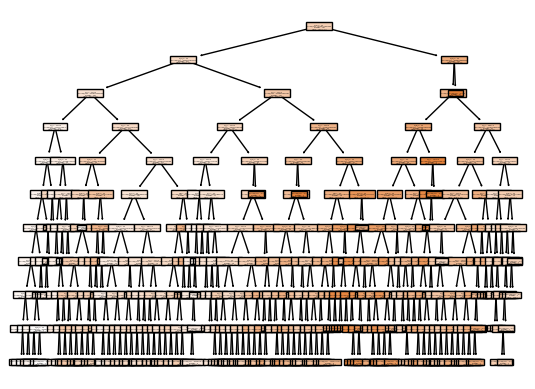

0.8732610360038179


In [68]:
#7
## Decision Trees sample code:
from sklearn import tree

model = tree.DecisionTreeRegressor(max_depth=10) # Fit the classifier
cart = model.fit(X_train, y_train)
tree.plot_tree(cart,filled=True)
plt.show()

## Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test)
residuals_cart = y_test - y_hat_cart


## Metrics:
N_test = len(y_test)
TSS = np.sum( (y_test - y_train.mean())**2 )
SSE_cart = np.sum( (y_test-y_hat_cart)**2 )
MSE_cart = (1/N_test)*np.sum( (y_test-y_hat_cart)**2 )
RMSE_cart = (SSE_cart/N_test)**(1/2)
R2_cart = 1 - SSE_cart/TSS
print(R2_cart)


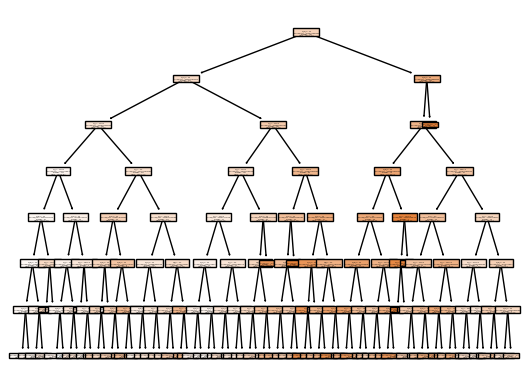

0.813791289292243


In [69]:
## Decision Trees sample code:
from sklearn import tree

model = tree.DecisionTreeRegressor(max_depth=7) # Fit the classifier
cart = model.fit(X_train, y_train)
tree.plot_tree(cart,filled=True)
plt.show()

## Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test)
residuals_cart = y_test - y_hat_cart


## Metrics:
N_test = len(y_test)
TSS = np.sum( (y_test - y_train.mean())**2 )
SSE_cart = np.sum( (y_test-y_hat_cart)**2 )
MSE_cart = (1/N_test)*np.sum( (y_test-y_hat_cart)**2 )
RMSE_cart = (SSE_cart/N_test)**(1/2)
R2_cart = 1 - SSE_cart/TSS
print(R2_cart)

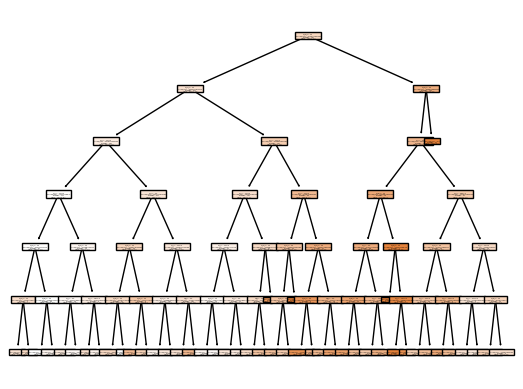

0.7854855438862035


In [70]:
## Decision Trees sample code:
from sklearn import tree

model = tree.DecisionTreeRegressor(max_depth=6) # Fit the classifier
cart = model.fit(X_train, y_train)
tree.plot_tree(cart,filled=True)
plt.show()

## Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test)
residuals_cart = y_test - y_hat_cart


## Metrics:
N_test = len(y_test)
TSS = np.sum( (y_test - y_train.mean())**2 )
SSE_cart = np.sum( (y_test-y_hat_cart)**2 )
MSE_cart = (1/N_test)*np.sum( (y_test-y_hat_cart)**2 )
RMSE_cart = (SSE_cart/N_test)**(1/2)
R2_cart = 1 - SSE_cart/TSS
print(R2_cart)

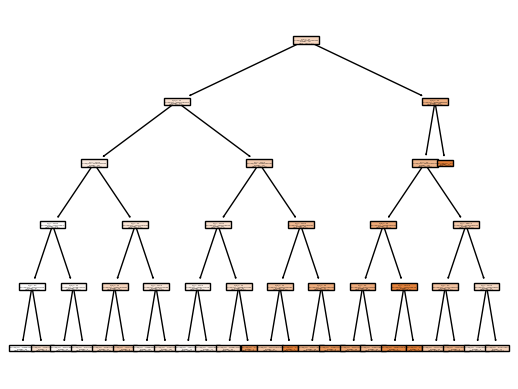

0.7797512855434181


In [71]:
## Decision Trees sample code:
from sklearn import tree

model = tree.DecisionTreeRegressor(max_depth=5) # Fit the classifier
cart = model.fit(X_train, y_train)
tree.plot_tree(cart,filled=True)
plt.show()

## Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test)
residuals_cart = y_test - y_hat_cart


## Metrics:
N_test = len(y_test)
TSS = np.sum( (y_test - y_train.mean())**2 )
SSE_cart = np.sum( (y_test-y_hat_cart)**2 )
MSE_cart = (1/N_test)*np.sum( (y_test-y_hat_cart)**2 )
RMSE_cart = (SSE_cart/N_test)**(1/2)
R2_cart = 1 - SSE_cart/TSS
print(R2_cart)

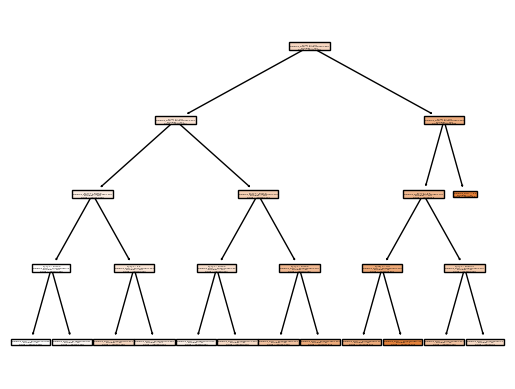

0.7438613118850443


In [72]:
## Decision Trees sample code:
from sklearn import tree

model = tree.DecisionTreeRegressor(max_depth=4) # Fit the classifier
cart = model.fit(X_train, y_train)
tree.plot_tree(cart,filled=True)
plt.show()

## Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test)
residuals_cart = y_test - y_hat_cart


## Metrics:
N_test = len(y_test)
TSS = np.sum( (y_test - y_train.mean())**2 )
SSE_cart = np.sum( (y_test-y_hat_cart)**2 )
MSE_cart = (1/N_test)*np.sum( (y_test-y_hat_cart)**2 )
RMSE_cart = (SSE_cart/N_test)**(1/2)
R2_cart = 1 - SSE_cart/TSS
print(R2_cart)

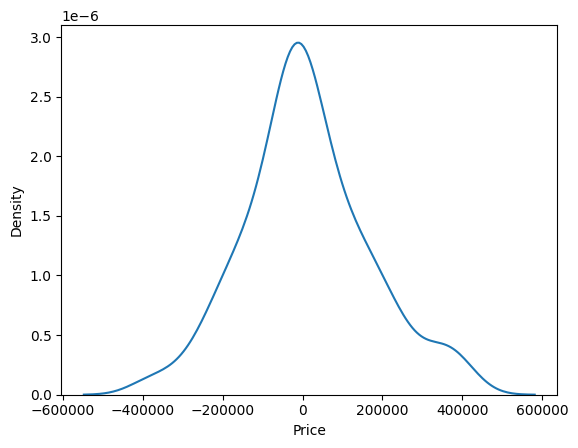

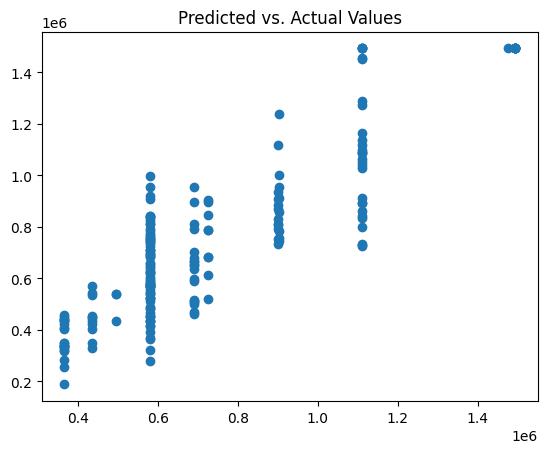

In [73]:
# Predicted values:
y_hat_t = cart.predict(X_test)
residuals_t = y_test - y_hat_t

## Residual plot:
sns.kdeplot(residuals_t)
plt.show()

## True versus predicted plot:
plt.scatter(x=y_hat_t,y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()

8. The the predicted values and true values do roughly line up along the diagonal. There are some of them that are off such as the top right of the graph. The kernel density plot does have a bell shape around zero.

9. The LinearRegression models did the best over the Decision Tree models. R2 values and RMSE was the highest with LinearRegression models compared to the tree models. Linear had a better accuracy.

**Q2.** The is a question about regression using decision trees and linear models. The data include wages at data science-y jobs, including

  - `Rating`: Company worker happiness score
  - `Size`: Number of employees
  - `Sector`: Part of the economy
  - `avg_salary`: Average wage
  - `job_state`: Location of work

  1. Load the `wages_hw.csv` file. Split the sample into an ~80% training set and a ~20% test set. Do any necessary cleaning, including outliers and missings.
  2. Use a linear model to regress `avg_salary` on `Sector`. Which sectors have the highest predicted wages? What is the $R^2$ and `RMSE` on the test set?
  3. Make a scatterplot of `avg_salary` and `Rating`. Is there an obvious visual relationship between the two variables? Regress `avg_salary` on `Rating` as a numeric variable: Do higher ratings predict higher or lower wages? Convert `Rating` to a one-hot encoded variable, with a category for each rating. Run a regression of `avg_salary` on the categorical version. How do your results change? Explain. Which version has a higher $R^2$ and lower `RMSE`?
  4. Now interact `Sector` with the categorical version of `Rating`, so your regressors are a (Sector, Rating) pair; this is a programming puzzle you'll have to think about, but using the `.PolynomialFeatures()` function on the one-hot encoded categorical variables is one option, and another is pre-processing a new variable that interacts `Sector` and `Rating` and then one-hot encoding the result. Regress `avg_salary` on the (Sector, Rating) pairs. How does the $R^2$ and `RMSE` on the test set compare to part 2? Interpret the coefficients; which sector-rating pairs have the highest wages?
  5. Run a linear regression of `avg_salary` on all the variables. What is the $R^2$ on the test set? How does it compare to your simpler models in 2--4?
  6. Build a decision tree by regressing `avg_salary` on `Sector`, `Rating`, and the (Sector, Rating) pairs. What are the $R^2$ and `RMSE` of your models on the test set? How do your answers compare to parts 2, 3, and 4?
  7. Build a decision tree by regressing `avg_salary` on all the other variables. What is the $R^2$ and `RMSE` on the test set?
  8. Build a linear regression or decision tree using the available variables based on your own judgment. What degrees of freedom are you giving the model to predict variation in wages across company and location attributes? What is the $R^2$ and `RMSE` of your model? How does it compare to the previous ones in the question? Why does yours perform better or worse on the test set?

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high
    - Husband's education (categorical) 1=low, 2, 3, 4=high
    - Number of children ever born (numerical)
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?
  2. Split the sample into ~80% training data and ~20% testing data.
  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.
  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?
  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.
  7. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

In [74]:
#1
df = pd.read_csv('./sample_data/contraception_hw.csv')

print(df.head())
#print(df.describe())
#df.head()
#print(df.dtypes)


df['method'].value_counts()
pd.crosstab(df['method'], df['numberChildren'])

   Unnamed: 0  age  edu  edu_spouse  numberChildren  religion  working  \
0           1   24    2           3               3         1        1   
1           2   45    1           3              10         1        1   
2           3   43    2           3               7         1        1   
3           4   42    3           2               9         1        1   
4           5   36    3           3               8         1        1   

   spouse_occupation  standardOfLivingIndex  mediaExposure  method  
0                  2                      3              0       1  
1                  3                      4              0       1  
2                  3                      4              0       1  
3                  3                      3              0       1  
4                  3                      2              0       1  


numberChildren,0,1,2,3,4,5,6,7,8,9,10,11,12,13,16
method,,,,,,,,,,,,,,,
1,95,143,114,70,57,44,35,18,29,5,9,6,4,0,0
2,0,46,56,70,62,36,27,19,9,3,2,2,0,1,0
3,2,87,106,119,78,55,30,12,9,8,0,3,0,1,1


If you combine both method 2 & 3 that uses any sort of birth control, they tend to have more kids. The couples that uses no birth control had fewer kids than those couples that did.  

In [75]:
#2
y = df["method"]
X = df.drop(["method"], axis=1)
X = X.drop(["Unnamed: 0"], axis=1)
# Test-train split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

[Text(0.4230769230769231, 0.875, 'x[3] <= 0.5\nsquared_error = 0.771\nsamples = 1178\nvalue = 1.927'),
 Text(0.15384615384615385, 0.625, 'x[0] <= 18.0\nsquared_error = 0.101\nsamples = 77\nvalue = 1.052'),
 Text(0.07692307692307693, 0.375, 'squared_error = 0.0\nsamples = 1\nvalue = 3.0'),
 Text(0.23076923076923078, 0.375, 'x[6] <= 3.5\nsquared_error = 0.052\nsamples = 76\nvalue = 1.026'),
 Text(0.15384615384615385, 0.125, 'squared_error = 0.0\nsamples = 72\nvalue = 1.0'),
 Text(0.3076923076923077, 0.125, 'squared_error = 0.75\nsamples = 4\nvalue = 1.5'),
 Text(0.6923076923076923, 0.625, 'x[0] <= 38.5\nsquared_error = 0.76\nsamples = 1101\nvalue = 1.988'),
 Text(0.5384615384615384, 0.375, 'x[3] <= 2.5\nsquared_error = 0.759\nsamples = 817\nvalue = 2.12'),
 Text(0.46153846153846156, 0.125, 'squared_error = 0.801\nsamples = 393\nvalue = 1.987'),
 Text(0.6153846153846154, 0.125, 'squared_error = 0.689\nsamples = 424\nvalue = 2.243'),
 Text(0.8461538461538461, 0.375, 'x[1] <= 3.5\nsquared_e

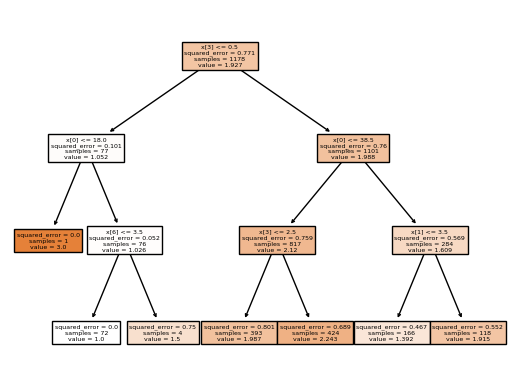

In [76]:
#3
model = tree.DecisionTreeRegressor(max_depth=3) # Fit the classifier
cart = model.fit(X_train, y_train)
tree.plot_tree(cart,filled=True)

This doesnt seem to classify our right type of method of contraceptive method. It has decimals values instead of int values so we dont know what method it is such as value 2.609. The reason for this error is that we are using DecisionTreeRegressor which treats the contraceptive method as numbers instead of categorized methods.

[Text(0.36363636363636365, 0.9, 'x[3] <= 0.5\ngini = 0.646\nsamples = 1178\nvalue = [500, 264, 414]'),
 Text(0.09090909090909091, 0.7, 'x[0] <= 18.0\ngini = 0.051\nsamples = 77\nvalue = [75, 0, 2]'),
 Text(0.045454545454545456, 0.5, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.13636363636363635, 0.5, 'x[6] <= 3.5\ngini = 0.026\nsamples = 76\nvalue = [75, 0, 1]'),
 Text(0.09090909090909091, 0.3, 'gini = 0.0\nsamples = 72\nvalue = [72, 0, 0]'),
 Text(0.18181818181818182, 0.3, 'x[4] <= 0.5\ngini = 0.375\nsamples = 4\nvalue = [3, 0, 1]'),
 Text(0.13636363636363635, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.22727272727272727, 0.1, 'gini = 0.0\nsamples = 3\nvalue = [3, 0, 0]'),
 Text(0.6363636363636364, 0.7, 'x[0] <= 37.5\ngini = 0.653\nsamples = 1101\nvalue = [425, 264, 412]'),
 Text(0.45454545454545453, 0.5, 'x[1] <= 3.5\ngini = 0.64\nsamples = 779\nvalue = [252, 173, 354]'),
 Text(0.36363636363636365, 0.3, 'x[3] <= 2.5\ngini = 0.611\nsamples = 481\nvalue = [184

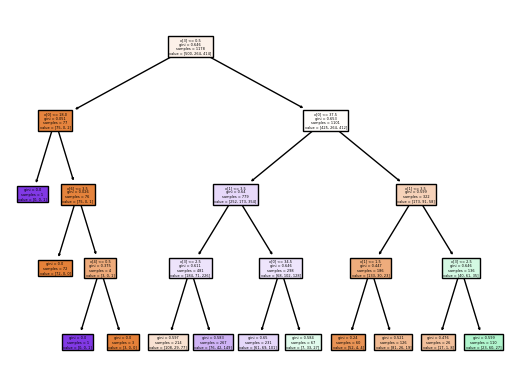

In [77]:
#4
model = tree.DecisionTreeClassifier(max_depth=4)
cart = model.fit(X_train, y_train)
tree.plot_tree(cart,filled=True)

Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What c does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?

We now have Gini values. We also now properly use categorized methods when we split at each node/split as they are whole numbers (1,2,3) When splitting. It uses the value df[x] to determine the split. In this case it uses "age edu numberChildren spouse_occupation" It seems that younger people use less likely to use no method of contraception

In [78]:
def performance(y_test,y_hat): # Sample code to compute classifier performance
    tab = pd.crosstab(np.array(y_hat),np.array(y_test)) # Compute confusion matrix
    #
    # Get entries from the confusion matrix:
    tp = tab.iloc[0,0]
    tn = tab.iloc[1,1]
    fp = tab.iloc[0,1]
    fn = tab.iloc[1,0]
    tot = tp+tn+fp+fn
    #
    # Compute performance statistics:
    acc = (tp+tn)/tot
    #

    return({'confusion_matrix':tab,
            'accuracy':acc
            })



In [79]:
#5
# Compute performance:
y_hat_lm = model.predict(X_test) # Compute predicted values from the model
perf_knn = performance(y_test,y_hat_lm)
print(perf_knn)


{'confusion_matrix': col_0   1   2   3
row_0            
1      83  12  26
2      10  21  10
3      36  36  61, 'accuracy': 0.8253968253968254}


Method 1 was 41% accurate
Method 2 was 28% accurate
Method 3 was 82% accurate
Overall it is 82% accruate.

In [80]:
#6 Why can't you use a linear probability model to do this exercise? Explain clearly in words.

We cant use linear probability as the independent and dependent values are not linear and we would not be able to gather useful Information.

**Q4.** This is a question where we use regression and regression trees. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running these regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q5.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{eqnarray*}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{eqnarray*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{eqnarray*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{eqnarray*}

which can be written in terms of sample covariance and sample variance as:

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{eqnarray*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
6. Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?

In [81]:
#